<a href="https://colab.research.google.com/github/brunoalexco/project3-drug-recommendation-ds-ml/blob/main/Drugs_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, auc, roc_curve,ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/brunoalexco/project3-drug-recommendation-ds-ml/main/drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


# **EXPLORATORY DATA ANALYSIS**

##Quick exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [ ]:
df['BP'].value_counts()

HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64

In [ ]:
df['Cholesterol'].value_counts()

HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

In [ ]:
df['Drug'].value_counts(normalize=True)

DrugY    0.455
drugX    0.270
drugA    0.115
drugC    0.080
drugB    0.080
Name: Drug, dtype: float64

In [ ]:
df['Sex'].value_counts()

M    104
F     96
Name: Sex, dtype: int64

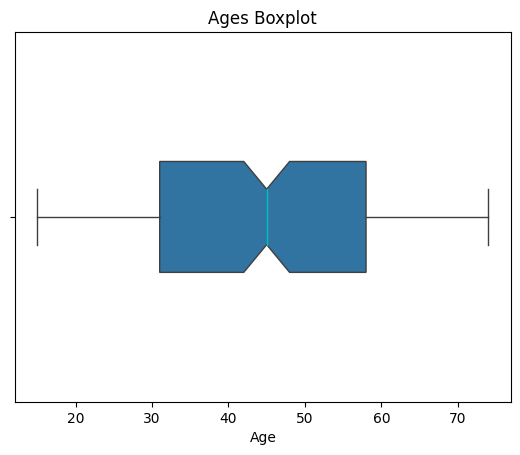

In [ ]:
sns.boxplot(x=df["Age"], data=df,notch = True,
            linewidth=1,
            medianprops={"color": "c", "linewidth": 1},
            width=0.3).set_title("Ages Boxplot")

plt.show();

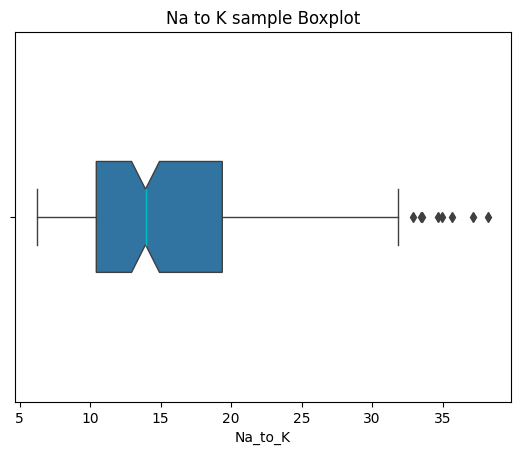

In [ ]:
sns.boxplot(x=df["Na_to_K"], data=df,notch = True,
            linewidth=1,
            medianprops={"color": "c", "linewidth": 1},
            width=0.3).set_title("Na to K sample Boxplot")

plt.show();

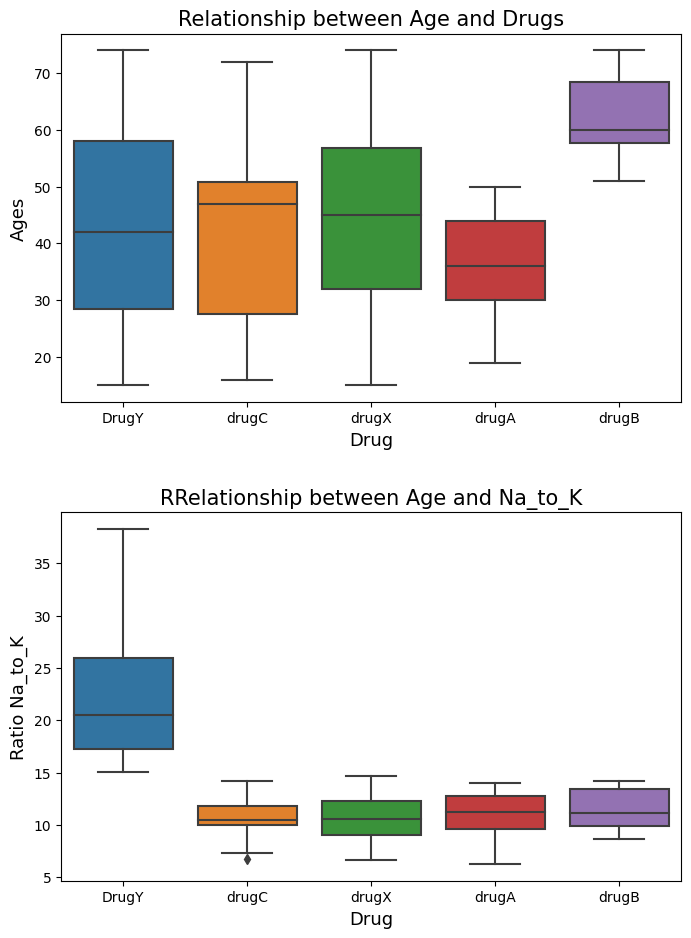

In [ ]:
plt.figure(figsize = (8,11))

plt.subplot(211)
ax = sns.boxplot(x='Drug', y='Age', data=df)
ax.set_title("Relationship between Age and Drugs", fontsize=15)
ax.set_xlabel("Drug", fontsize=13)
ax.set_ylabel("Ages", fontsize=13)

plt.subplot(212)
ax = sns.boxplot(x='Drug', y='Na_to_K', data=df)
ax.set_title("RRelationship between Age and Na_to_K", fontsize=15)
ax.set_xlabel("Drug", fontsize=13)
ax.set_ylabel("Ratio Na_to_K", fontsize=13)

plt.subplots_adjust(hspace=0.3)

plt.show()

##Notes

From the data exploration we can conclude the following:

1. There are no or minimal anomalies in the data: missing values, incorrect categories, some outliers in the column of the ratio between Sodium and Potassium.

2. Regarding the data balance, the drug Y predominates with 45% while drugs C and B have 8%. Having a small dataset, we cannot do downsampling. We will take this into account when processing the dataset and analyzing the metrics correctly.

3. There is a correlation between the type of drugs administered and RatioNaK. Y is administered in ages between 17 and 25 while the others are between 15 or less. This is probably due to the tolerance that some patients have to DrugY.

4. Regarding the ages, we can also appreciate that the drug B is administered in older people than the others.

# **PREPROCESSING**

* Age: numeric

* BP: ordinal

* Cholesterol: ordinal

* Na_to_K: numeric

* Sex: nominal

* Drug: nominal

In [ ]:
df['BP'].replace({'LOW':0, 'NORMAL':1, 'HIGH':2},inplace=True)
df['Cholesterol'].replace({'NORMAL':0, 'HIGH':1},inplace=True)
df['Drug'].replace({'DrugY':0,'drugX':1,'drugA':2,'drugC':3,'drugB':4},inplace=True)

<ipython-input-29-753ca5bff919>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

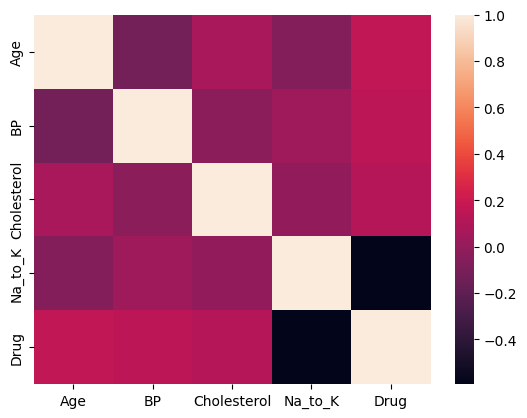

In [ ]:
corr = df.corr()
sns.heatmap(corr)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    int64  
 3   Cholesterol  200 non-null    int64  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 9.5+ KB


In [ ]:
X = df.drop(columns='Drug')
y = df['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y,random_state=42)

In [ ]:
int_selector = make_column_selector(dtype_include='int')
float_selector = make_column_selector(dtype_include='float')
cat_selector = make_column_selector(dtype_include='object')

imputer_int = SimpleImputer(strategy='median')
imputer_float = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = make_column_transformer((make_pipeline(imputer_int, scaler), int_selector),
                             (make_pipeline(imputer_float, scaler), float_selector),
                                       (make_pipeline(imputer_cat, ohe), cat_selector),remainder='passthrough')

pipeline = make_pipeline(preprocessor)

pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7da6d3a30100>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImp...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7da6d3de14b0>),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7da6d3a30130>)]))])

In [ ]:
pipeline.fit(X_train)

X_train_processed = pipeline.transform(X_train)
X_test_processed = pipeline.transform(X_test)

X_train_processed = pd.DataFrame(X_train_processed, columns=pipeline.get_feature_names_out())
X_test_processed = pd.DataFrame(X_test_processed, columns=pipeline.get_feature_names_out())

X_train_processed

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,pipeline-1__Age,pipeline-1__BP,pipeline-1__Cholesterol,pipeline-2__Na_to_K,pipeline-3__Sex_F,pipeline-3__Sex_M
0,-0.477739,-1.275318,-0.958023,-0.572505,1.0,0.0
1,-0.958483,1.089510,1.043816,1.874614,1.0,0.0
2,0.063098,1.089510,1.043816,2.609142,1.0,0.0
3,-1.799784,1.089510,-0.958023,0.089496,1.0,0.0
4,1.084678,-0.092904,1.043816,1.378989,0.0,1.0
...,...,...,...,...,...,...
135,1.745701,-1.275318,1.043816,0.681075,1.0,0.0
136,-0.237367,-0.092904,-0.958023,0.956453,1.0,0.0
137,-1.739692,1.089510,-0.958023,0.409625,0.0,1.0
138,0.664027,-1.275318,1.043816,-0.150390,0.0,1.0


# **MACHINE LEARNING MODELS**

## Decicion Tree

###Model

In [ ]:
dectree = DecisionTreeClassifier()
dectree.fit(X_train_processed, y_train)
dt_train_score = dectree.score(X_train_processed, y_train)
dt_test_score = dectree.score(X_test_processed, y_test)
print(dt_train_score)
print(dt_test_score)

1.0
0.9833333333333333


We only got 1 error when analyzing the test, we are on the right track with this model.



###Report

In [ ]:
y_preds_dt = dectree.predict(X_test_processed)
dectree_clreport = classification_report(y_test, y_preds_dt)
print(dectree_clreport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        16
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5

    accuracy                           0.98        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.99      0.98      0.98        60



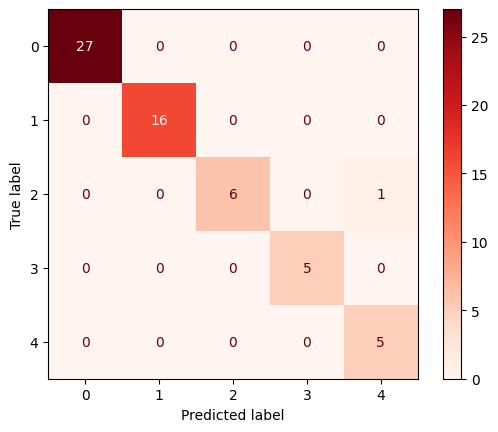

In [ ]:
ConfusionMatrixDisplay.from_estimator(dectree, X_test_processed, y_test, cmap = 'Reds');

##Random Forest

###Model

In [ ]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train_processed, y_train)
rf_train_score = ranfor.score(X_train_processed, y_train)
rf_test_score = ranfor.score(X_test_processed, y_test)
print(rf_train_score)
print(rf_test_score)

1.0
1.0


In [ ]:
param_grid =  {"max_depth": [6,7,8,9,10,11],"max_leaf_nodes":[14,15,16,17,18],"n_estimators": [16,17,18,19,20]}
rf_class = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_class, param_grid, refit=True)
grid_search.fit(X_train_processed,y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11],
                         'max_leaf_nodes': [14, 15, 16, 17, 18],
                         'n_estimators': [16, 17, 18, 19, 20]})

In [ ]:
print("Mejor modelo: ", grid_search.best_estimator_)
print("Mejor score: ",grid_search.best_score_)
print("Mejores parámetros: ",grid_search.best_params_)

Mejor modelo:  RandomForestClassifier(max_depth=6, max_leaf_nodes=14, n_estimators=20,
                       random_state=42)
Mejor score:  0.9642857142857142
Mejores parámetros:  {'max_depth': 6, 'max_leaf_nodes': 14, 'n_estimators': 20}


In [ ]:
best_rf_train = grid_search.score(X_train_processed, y_train)
best_rf_test = grid_search.score(X_test_processed, y_test)
print(best_rf_train)
print(best_rf_test)

1.0
0.95


###Report

In [ ]:
y_preds_rf = grid_search.predict(X_test_processed)
rf_clreport = classification_report(y_test, y_preds_rf)
print(rf_clreport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.89      1.00      0.94        16
           2       1.00      0.86      0.92         7
           3       1.00      0.60      0.75         5
           4       0.83      1.00      0.91         5

    accuracy                           0.95        60
   macro avg       0.94      0.89      0.90        60
weighted avg       0.96      0.95      0.95        60



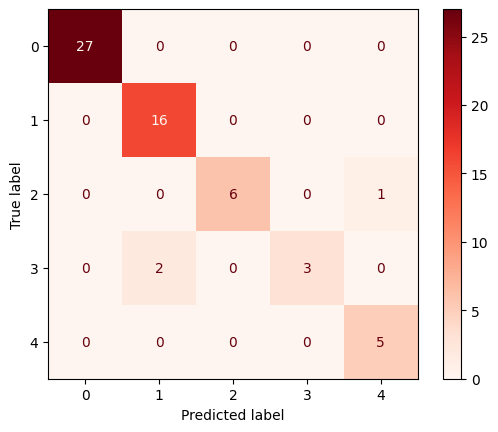

In [ ]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test_processed, y_test, cmap = 'Reds')

The model has problems in recommending the correct drug, it only recommended drug 3 in 60% of the cases, in the rest it recommended drug 1 which was not correct.

** For some reason, when running the model recommended by the grid, it has worse performance than the standard random forest model, which has 1.

##Bagging Classifier

###Model

In [ ]:
bagcla  = BaggingClassifier()
bagcla.fit(X_train_processed, y_train)
bc_train_score = bagcla.score(X_train_processed, y_train)
bc_test_score = bagcla.score(X_test_processed, y_test)
print(bc_train_score)
print(bc_test_score)

0.9928571428571429
1.0


In [ ]:
param_grid =  {"n_estimators": [13,14,15,16,17,18]}
bagreg_opt = BaggingClassifier(random_state=42)
bcgrid = GridSearchCV(bagreg_opt, param_grid, refit=True)
bcgrid.fit(X_train_processed,y_train)

GridSearchCV(estimator=BaggingClassifier(random_state=42),
             param_grid={'n_estimators': [13, 14, 15, 16, 17, 18]})

In [ ]:
print("Mejor modelo: ", bcgrid.best_estimator_)
print("Mejor score: ",bcgrid.best_score_)
print("Mejores parámetros: ",bcgrid.best_params_)

Mejor modelo:  BaggingClassifier(n_estimators=13, random_state=42)
Mejor score:  0.9857142857142858
Mejores parámetros:  {'n_estimators': 13}


###Report

In [ ]:
y_preds_bc = bcgrid.predict(X_test_processed)
bc_clreport = classification_report(y_test, y_preds_bc)
print(bc_clreport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        16
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5

    accuracy                           0.98        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.99      0.98      0.98        60



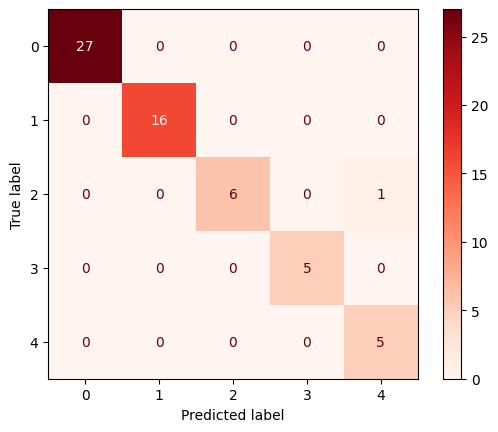

In [ ]:
ConfusionMatrixDisplay.from_estimator(bcgrid, X_test_processed, y_test, cmap = 'Reds')

##KNN

###Model

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_processed, y_train)
knn_train_score = knn.score(X_train_processed, y_train)
knn_test_score = knn.score(X_test_processed, y_test)
print(knn_train_score)
print(knn_test_score)

0.8928571428571429
0.7833333333333333


In [ ]:
param_grid =  {'n_neighbors': list(range(2,30)), 'weights': ['uniform', 'distance']}
knn_opt = KNeighborsClassifier()
knngrid = GridSearchCV(knn_opt, param_grid, refit=True)
knngrid.fit(X_train_processed,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29],
                         'weights': ['uniform', 'distance']})

In [ ]:
print("Mejor modelo: ", knngrid.best_estimator_)
print("Mejor score: ",knngrid.best_score_)
print("Mejores parámetros: ",knngrid.best_params_)

Mejor modelo:  KNeighborsClassifier(n_neighbors=11, weights='distance')
Mejor score:  0.9
Mejores parámetros:  {'n_neighbors': 11, 'weights': 'distance'}


###Report

In [ ]:
y_preds_knn = knngrid.predict(X_test_processed)
knn_clreport = classification_report(y_test, y_preds_knn)
print(knn_clreport)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        27
           1       0.83      0.94      0.88        16
           2       0.88      1.00      0.93         7
           3       1.00      1.00      1.00         5
           4       1.00      0.40      0.57         5

    accuracy                           0.88        60
   macro avg       0.92      0.85      0.86        60
weighted avg       0.89      0.88      0.88        60



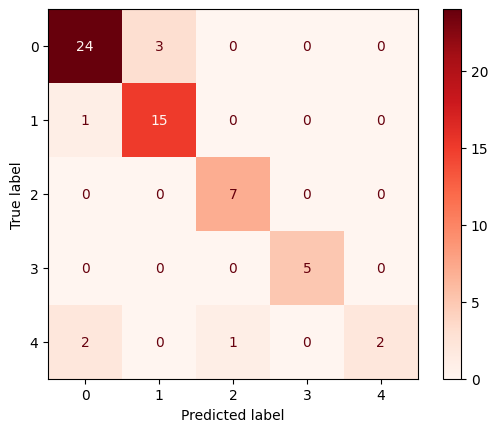

In [ ]:
ConfusionMatrixDisplay.from_estimator(knngrid, X_test_processed, y_test, cmap = 'Reds')

##Logistic Regression

###Model

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_processed, y_train)
lg_train_score = logreg.score(X_train_processed, y_train)
lg_test_score = logreg.score(X_test_processed, y_test)
print(lg_train_score)
print(lg_test_score)

0.9571428571428572
0.95


In [ ]:
lrparam_grid =  {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'], 'multi_class': ['ovr', 'multinomial'], 'solver': ['liblinear']}
lr_opt = LogisticRegression()
lrgrid = GridSearchCV(lr_opt, lrparam_grid, refit=True)
lrgrid.fit(X_train_processed,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback 

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [ ]:
print("Mejor modelo: ", lrgrid.best_estimator_)
print("Mejor score: ",lrgrid.best_score_)
print("Mejores parámetros: ",lrgrid.best_params_)

Mejor modelo:  LogisticRegression(C=10, multi_class='ovr', solver='liblinear')
Mejor score:  0.9428571428571428
Mejores parámetros:  {'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}


###Report

In [ ]:
y_lrpreds = lrgrid.predict(X_test_processed)
lr_clreport = classification_report(y_test, y_lrpreds)
print(lr_clreport)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        27
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         5
           4       1.00      0.60      0.75         5

    accuracy                           0.95        60
   macro avg       0.98      0.91      0.93        60
weighted avg       0.95      0.95      0.95        60



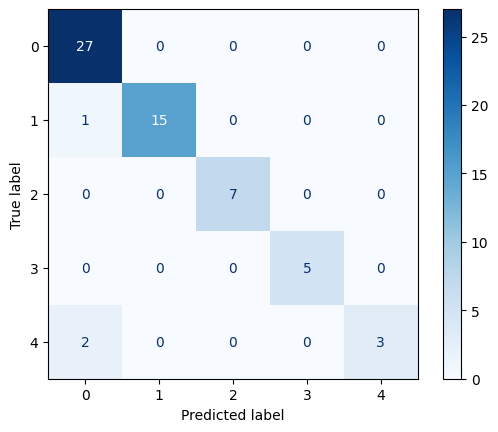

In [ ]:
ConfusionMatrixDisplay.from_estimator(lrgrid, X_test_processed, y_test, cmap='Blues')

##LightGBM

###Model

In [ ]:
lgbm = LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train_processed, y_train)
lgbm_train_score = lgbm.score(X_train_processed, y_train)
lgbm_test_score = lgbm.score(X_test_processed, y_test)
print(lgbm_train_score)
print(lgbm_test_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 6
[LightGBM] [Info] Start training from score -0.782759
[LightGBM] [Info] Start training from score -1.304056
[LightGBM] [Info] Start training from score -2.169054
[LightGBM] [Info] Start training from score -2.543747
[LightGBM] [Info] Start training from score -2.543747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [ ]:
lgbmparam_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [-1, 5, 10],
    'n_estimators': [100, 200, 500],
}
lgbm_opt = LGBMClassifier()
lgbmgrid = GridSearchCV(lgbm_opt, lgbmparam_grid, refit=True)
lgbmgrid.fit(X_train_processed,y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [-1, 5, 10],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [31, 63, 127]})

In [ ]:
print("Mejor modelo: ", lgbmgrid.best_estimator_)
print("Mejor score: ",lgbmgrid.best_score_)
print("Mejores parámetros: ",lgbmgrid.best_params_)

Mejor modelo:  LGBMClassifier(n_estimators=200)
Mejor score:  0.9928571428571429
Mejores parámetros:  {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31}


###Report

In [ ]:
y_lgbmpreds = lgbmgrid.predict(X_test_processed)
lgbm_clreport = classification_report(y_test, y_lgbmpreds)
print(lgbm_clreport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        16
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5

    accuracy                           0.98        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.99      0.98      0.98        60



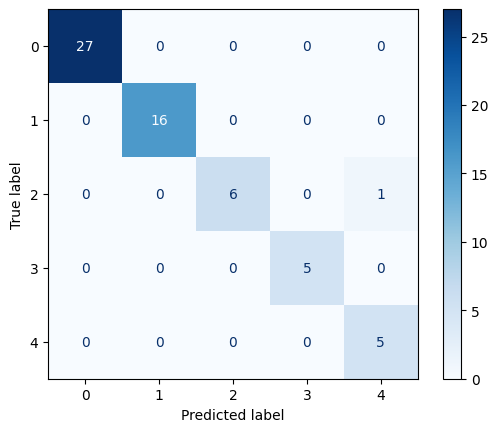

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbmgrid, X_test_processed, y_test, cmap='Blues')

##XGBoost

###Model

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_processed, y_train)
xgbm_train_score = xgb.score(X_train_processed, y_train)
xgbm_test_score = xgb.score(X_test_processed, y_test)
print(xgbm_train_score)
print(xgbm_test_score)

1.0
0.9666666666666667


In [ ]:
xgbparam_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
xgb_opt = XGBClassifier()
xgbgrid = GridSearchCV(xgb_opt, xgbparam_grid, refit=True)
xgbgrid.fit(X_train_processed,y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 4, 6], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 500]})

In [ ]:
print("Mejor modelo: ", xgbgrid.best_estimator_)
print("Mejor score: ",xgbgrid.best_score_)
print("Mejores parámetros: ",xgbgrid.best_params_)

Mejor modelo:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Mejor score:  0.9857142857142858
Mejores parámetros:  {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200}


###Report

In [ ]:
y_xgbpreds = xgbgrid.predict(X_test_processed)
xgb_clreport = classification_report(y_test, y_xgbpreds)
print(xgb_clreport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.94      1.00      0.97        16
           2       1.00      1.00      1.00         7
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5

    accuracy                           0.98        60
   macro avg       0.99      0.96      0.97        60
weighted avg       0.98      0.98      0.98        60



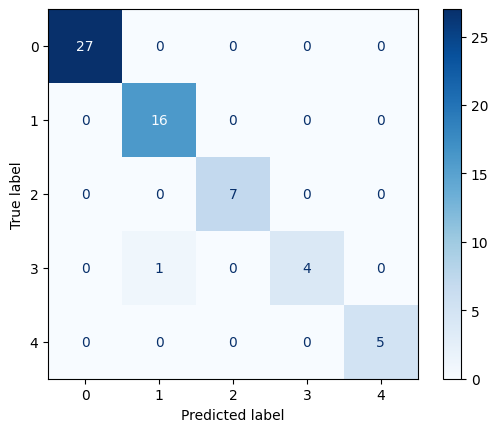

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgbgrid, X_test_processed, y_test, cmap='Blues')

##Gadient Boosting

###Model

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_processed, y_train)
gbc_train_score = gbc.score(X_train_processed, y_train)
gbc_test_score = gbc.score(X_test_processed, y_test)
print(gbc_train_score)
print(gbc_test_score)

1.0
0.9666666666666667


In [ ]:
gbcparam_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [2, 4, 6],
    'criterion': ['friedman_mse', 'mae'],
    'subsample': [0.6, 0.8, 1.0],
}
gbc_opt = GradientBoostingClassifier()
gbcgrid = GridSearchCV(gbc_opt, gbcparam_grid, refit=True)
gbcgrid.fit(X_train_processed,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'criterion': ['friedman_mse', 'mae'],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.6, 0.8, 1.0]})

In [ ]:
print("Mejor modelo: ", gbcgrid.best_estimator_)
print("Mejor score: ", gbcgrid.best_score_)
print("Mejores parámetros: ", gbcgrid.best_params_)

Mejor modelo:  GradientBoostingClassifier(max_depth=2, subsample=0.6)
Mejor score:  0.9857142857142858
Mejores parámetros:  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.6}


###Report

In [ ]:
y_gbcpreds = gbcgrid.predict(X_test_processed)
gbc_clreport = classification_report(y_test, y_gbcpreds)
print(gbc_clreport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        16
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5

    accuracy                           0.98        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.99      0.98      0.98        60



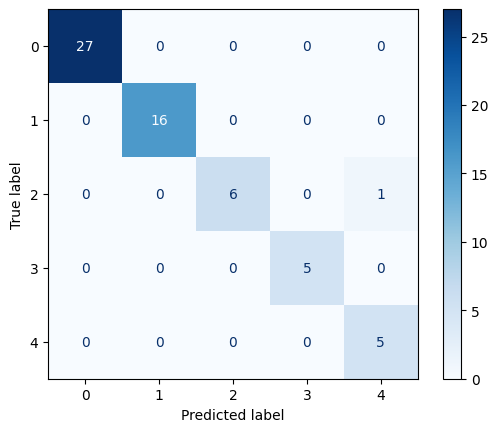

In [ ]:
ConfusionMatrixDisplay.from_estimator(gbcgrid, X_test_processed, y_test, cmap='Blues')

# **CONCLUSION**

On this occasion we tested 8 ML models for classification optimized with GridSeearchCV, of which 5 had higher accuracy, precision and recall than the rest. Let’s review them:

98% - Decision Tree Classifier, LightGBM, XGBoost, Gradient Boosting, Bagging Classifier

95% - Logistic Regression, Random Forest

88% - KNN

Analyzing the results of the classification report, Decision Tree Classifier, LightGBM, Gradient Boosting, Bagging Classifier were wrong on 1 occasion when recommending DrugB when they should have recommended DrugA. XGBoost was wrong on 1 occasion when recommending DrugX when it should have recommended DrugC.

When analyzing the relationship of these medicines with age and the Na/K ratio, between DrugB and DrugA there is a marked difference in prescribing in different age ranges, DrugB is mostly prescribed for people around 60 years old and DrugA is prescribed for people around 35 years old, this can be an indicator that this error can be serious. Between DrugX and DrugC we did not find major differences between ages and Na/K ratios so if there is an error, it probably will not have major repercussions than those that would have with an error between the previous drugs.

In conclusion, I will decide to choose the XGBoost model over the others to minimize the consequences of the errors that may occur in the future.

In [ ]:
int_selector = make_column_selector(dtype_include='int')
float_selector = make_column_selector(dtype_include='float')
cat_selector = make_column_selector(dtype_include='object')

imputer_int = SimpleImputer(strategy='median')
imputer_float = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = make_column_transformer((make_pipeline(imputer_int, scaler), int_selector),
                             (make_pipeline(imputer_float, scaler), float_selector),
                                       (make_pipeline(imputer_cat, ohe), cat_selector),remainder='passthrough')

pipeline = make_pipeline(preprocessor,xgbgrid)

pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7da6d0cc11b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImp...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                                          'learning_rate': [0.1, 0.01, 0.001],
                                          'max_depth': [2, 4, 6],
                                          'min_child_weight': [1, 3, 5],
                                          'n_estimators': [100, 200, 500]}))])